C:\Users\devia\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\devia\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\devia/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


100%|█████████████████████████████████████████████████████████████████████████████| 13.6M/13.6M [00:05<00:00, 2.44MB/s]
C:\Users\devia\AppData\Local\Temp\ipykernel_3368\3082820322.py:59: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\devia\AppData\Roaming\Python\Python313\site-packages\torch\amp\grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
C:\Users\devia\AppData\Local\Temp\ipykernel_3368\3082820322.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\devia\AppData\Roaming\Python\Python313\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[MobileNetV2] Epoch 1/15 Train Acc=0.8515 Val Acc=0.9299
[MobileNetV2] Epoch 2/15 Train Acc=0.9010 Val Acc=0.9411
[MobileNetV2] Epoch 3/15 Train Acc=0.9106 Val Acc=0.9475
[MobileNetV2] Epoch 4/15 Train Acc=0.9300 Val Acc=0.9506
[MobileNetV2] Epoch 5/15 Train Acc=0.9307 Val Acc=0.9490
[MobileNetV2] Epoch 6/15 Train Acc=0.9334 Val Acc=0.9634
[MobileNetV2] Epoch 7/15 Train Acc=0.9294 Val Acc=0.9490
[MobileNetV2] Epoch 8/15 Train Acc=0.9352 Val Acc=0.9554
[MobileNetV2] Epoch 9/15 Train Acc=0.9427 Val Acc=0.9570
[MobileNetV2] Epoch 10/15 Train Acc=0.9311 Val Acc=0.9634
[MobileNetV2] Epoch 11/15 Train Acc=0.9410 Val Acc=0.9713
[MobileNetV2] Epoch 12/15 Train Acc=0.9451 Val Acc=0.9666
[MobileNetV2] Epoch 13/15 Train Acc=0.9488 Val Acc=0.9618
[MobileNetV2] Epoch 14/15 Train Acc=0.9481 Val Acc=0.9634
[MobileNetV2] Epoch 15/15 Train Acc=0.9512 Val Acc=0.9666

Best Val Accuracy: 0.9713375796178344


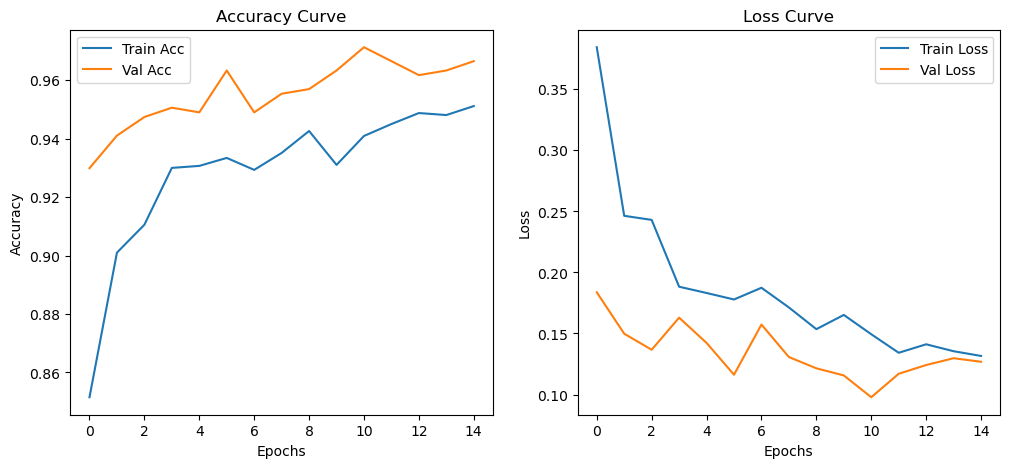


===== Final Metrics (MobileNetV2) =====
Accuracy: 0.9713375796178344
Precision: 0.9724598625740095
Recall: 0.9713375796178344
F1-Score: 0.9711162668962235
Specificity: 0.9569292833412435
MSE: 0.09554140127388536
LogLoss: 0.09778400888256755
AUC-ROC: 0.996828098013404

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95       172
           1       0.99      0.98      0.99       196
           2       0.97      0.86      0.91        86
           3       1.00      1.00      1.00       174

    accuracy                           0.97       628
   macro avg       0.97      0.96      0.96       628
weighted avg       0.97      0.97      0.97       628



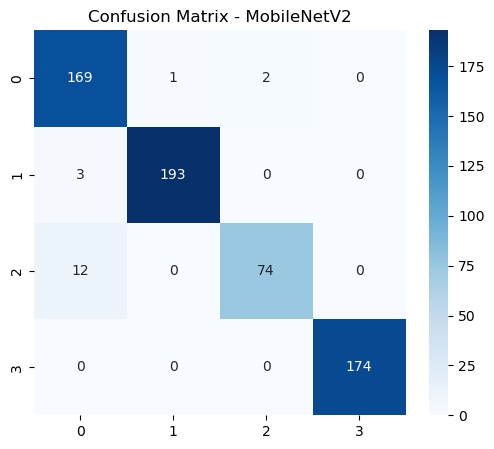

In [1]:
# =========================
# MobileNetV2 for Maize Leaf Detection
# =========================
import os, torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import models, datasets, transforms as T
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, mean_squared_error, log_loss, roc_auc_score,
    classification_report
)
import numpy as np

# ========= Dataset =========
DATA_DIR = r"D:\maize_project\Dataset"  # Already split into train/val
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "val")

NUM_CLASSES = len(os.listdir(TRAIN_DIR))
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 15
PATIENCE = 5
SAVE_PATH = "mobilenetv2_maize.pth"

# ========= Transforms =========
train_tf = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.RandomRotation(20),
    T.ColorJitter(brightness=0.2, contrast=0.15, saturation=0.15),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_tf = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tf)
val_ds   = datasets.ImageFolder(VAL_DIR, transform=val_tf)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ========= Model =========
model = models.mobilenet_v2(pretrained=True)
in_f = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_f, NUM_CLASSES)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)
scaler = GradScaler()

# ========= Evaluation =========
def evaluate(net, loader):
    net.eval(); correct=total=loss_sum=0
    with torch.no_grad():
        for xb,yb in loader:
            xb,yb = xb.to(DEVICE), yb.to(DEVICE)
            out = net(xb); loss = criterion(out,yb).item()
            _,pred = out.max(1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
            loss_sum += loss * yb.size(0)
    return correct/total, loss_sum/total

# ========= Training =========
train_acc_history, val_acc_history = [], []
train_loss_history, val_loss_history = [], []
best = 0
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for xb,yb in train_loader:
        xb,yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()

        with autocast():
            out = model(xb)
            loss = criterion(out,yb)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * yb.size(0)
        _,pred = out.max(1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)

    train_acc = correct / total
    train_loss = running_loss / total
    val_acc, val_loss = evaluate(model, val_loader)

    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    print(f"[MobileNetV2] Epoch {epoch+1}/{EPOCHS} Train Acc={train_acc:.4f} Val Acc={val_acc:.4f}")

    if val_acc > best:
        best = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), SAVE_PATH)
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            break

print("\nBest Val Accuracy:", best)

# ========= Plot Curves =========
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_acc_history, label='Train Acc')
plt.plot(val_acc_history, label='Val Acc')
plt.title("Accuracy Curve"); plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend()

plt.subplot(1,2,2)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.title("Loss Curve"); plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend()
plt.show()

# ========= Final Evaluation =========
model.load_state_dict(torch.load(SAVE_PATH))
model.eval()
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for xb,yb in val_loader:
        xb,yb = xb.to(DEVICE), yb.to(DEVICE)
        out = model(xb)
        probs = torch.softmax(out, dim=1)
        preds = torch.argmax(probs, dim=1)

        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# ========= Metrics =========
acc = accuracy_score(y_true,y_pred)
prec = precision_score(y_true,y_pred,average="weighted")
rec = recall_score(y_true,y_pred,average="weighted")
f1 = f1_score(y_true,y_pred,average="weighted")
cm = confusion_matrix(y_true,y_pred)
spec = np.diag(cm) / cm.sum(axis=1)
spec = np.nanmean(spec)
mse = mean_squared_error(y_true,y_pred)
ll = log_loss(y_true,y_prob)
try:
    auc = roc_auc_score(y_true,y_prob, multi_class="ovr")
except:
    auc = None

print("\n===== Final Metrics (MobileNetV2) =====")
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-Score:", f1)
print("Specificity:", spec)
print("MSE:", mse)
print("LogLoss:", ll)
print("AUC-ROC:", auc)
print("\nClassification Report:\n", classification_report(y_true,y_pred))

# ========= Confusion Matrix Plot =========
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - MobileNetV2")
plt.show()
